# Проект (PJ)

## Выполнил: Зимаков Максим Александрович

## Соревнование на Kaggle

[Ссылка на приглашение](https://www.kaggle.com/t/d92066c3eaec4b89bd97990706f89124)

В этом соревновании вам предлагается задача из области компьютерного зрения – распознавание букв английского алфавита на искаженных и зашумленных изображениях.

Примеры:

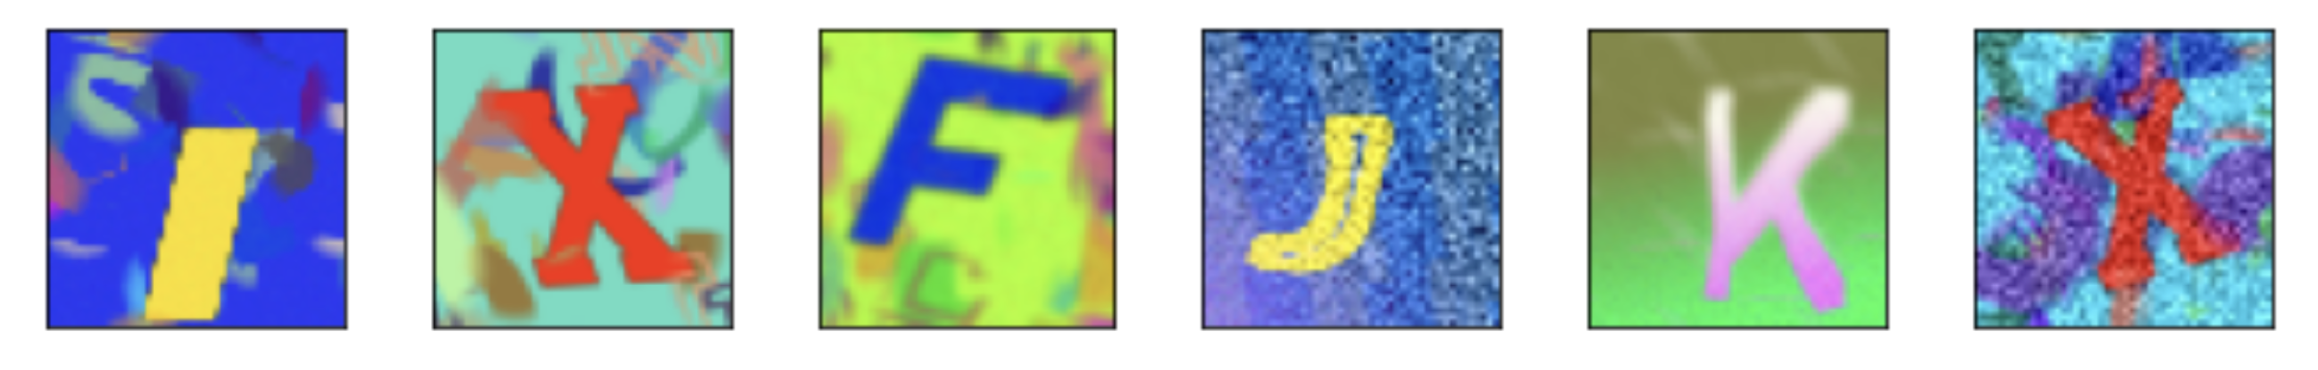

Данные для обучения содержатся в двух файлах: images.npy и labels.npy. Это формат numpy-массивов.

Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовыми каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). В массиве labels содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс — буква Z.

Ваша задача — обучить нейронную сеть и с ее помощью предсказать метки классов для изображений из файла images_sub.npy, в нем 50 тысяч изображений. Посмотрите на структуру файла sample_submission.csv — он не содержит полезных данных, а лишь описывает формат, в котором вы загружаете ваши предсказания на сайт. Создайте из ваших предсказаний такой же файл и загрузите в качестве вашего ответа (сабмита). Вы можете делать до 20 сабмитов в сутки.

Метрика лидерборда — accuracy, то есть доля правильно распознанных изображений.

Нотбук с базовым решением расположен в Google Colab. Попробуйте решить задачу, не обращаясь к нему. Задача будет считаться решенной, если в Public Leaderboard вы наберете score, который будет равен или больше 0.82.

## Решение

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
import pandas as pd

# Настройка стабильности обучения
tf.keras.mixed_precision.set_global_policy('float32')

In [15]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')
print("Доступные GPU:", tf.config.list_physical_devices('GPU'))
print("TensorFlow использует GPU:", tf.test.is_gpu_available())

Доступные GPU: []
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow использует GPU: False


In [16]:
# Загрузка данных
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

In [17]:
images

array([[[[144, 109, 189],
         [153, 122, 179],
         [169, 143, 163],
         ...,
         [158, 130, 175],
         [149, 117, 183],
         [131,  91, 200]],

        [[128,  87, 203],
         [138, 101, 193],
         [160, 132, 172],
         ...,
         [158, 129, 175],
         [152, 121, 181],
         [132,  93, 199]],

        [[127,  86, 204],
         [135,  96, 197],
         [145, 111, 188],
         ...,
         [158, 129, 175],
         [152, 121, 181],
         [132,  93, 198]],

        ...,

        [[147, 115, 185],
         [159, 131, 174],
         [168, 142, 165],
         ...,
         [159, 130, 174],
         [154, 123, 179],
         [137, 100, 194]],

        [[130,  90, 201],
         [143, 108, 189],
         [165, 138, 168],
         ...,
         [159, 130, 175],
         [153, 122, 180],
         [131,  91, 200]],

        [[130,  90, 201],
         [138, 102, 194],
         [139, 102, 193],
         ...,
         [158, 129, 175],
        

In [18]:
labels.shape

(20000,)

In [19]:
images.shape

(20000, 48, 48, 3)

In [20]:
# 1. Простая предобработка данных
def preprocess_data(images):
    """Нормализация изображений в диапазон [0, 1]"""
    return images.astype(np.float32) / 255.0

In [21]:
# 2. Простой генератор данных с базовой аугментацией
class SimpleDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels=None, batch_size=64, augment=True, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        
        self.indices = np.arange(len(images))
        if shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return (len(self.images) + self.batch_size - 1) // self.batch_size  # Включаем последний неполный батч
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.images))  # Ограничиваем конец
        batch_indices = self.indices[start_idx:end_idx]
        batch_images = self.images[batch_indices].copy()
        
        # Простая аугментация через TensorFlow
        if self.augment:
            batch_images = tf.image.random_flip_left_right(batch_images)
            batch_images = tf.image.random_brightness(batch_images, 0.1)
            batch_images = tf.image.random_contrast(batch_images, 0.9, 1.1)
            batch_images = batch_images.numpy()
        
        # Предобработка
        batch_images = preprocess_data(batch_images)
        
        if self.labels is not None:
            batch_labels = self.labels[batch_indices]
            return batch_images, batch_labels
        
        return batch_images

In [22]:
# 3. Создание модели
def create_custom_cnn(num_classes=26):
    """Создание собственной CNN архитектуры"""
    model = tf.keras.Sequential([
        layers.Input(shape=(48, 48, 3)),
        
        # Первый блок
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        
        # Второй блок
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.15),
        
        # Третий блок
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Четвертый блок
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        
        # Классификатор
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    return model

In [23]:
# 4. Функция обучения модели
def train_model(X_train, X_val, y_train, y_val):
    """Обучение модели с оптимальными параметрами"""
    
    print("Создание и компиляция модели...")
    model = create_custom_cnn()
    print(f"Количество параметров: {model.count_params():,}")
    
    # Компиляция модели
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Создание генераторов данных
    train_gen = SimpleDataGenerator(X_train, y_train, batch_size=64, augment=True)
    val_gen = SimpleDataGenerator(X_val, y_val, batch_size=64, augment=False, shuffle=False)
    
    # Настройка коллбэков
    callbacks_list = [
        callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1,
            monitor='val_accuracy',
            mode='max'
        ),
        callbacks.ModelCheckpoint(
            'best_custom_model.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
    ]
    
    print("Начинаем обучение...")
    history = model.fit(
        train_gen,
        epochs=100,
        validation_data=val_gen,
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Финальная оценка
    final_loss, final_acc = model.evaluate(val_gen, verbose=0)
    print(f"Финальная точность на валидации: {final_acc:.4f}")
    
    return model, history, final_acc

In [24]:
# 5. Создание предсказаний
def create_predictions(model):
    """Создание файла с предсказаниями"""
    try:
        print("Загрузка тестовых данных...")
        test_images = np.load('data/images_sub.npy')
        print(f"Загружено тестовых изображений: {test_images.shape}")
        
        # Создание генератора для тестовых данных
        test_gen = SimpleDataGenerator(test_images, labels=None, batch_size=64, 
                                     augment=False, shuffle=False)
        
        print("Создание предсказаний...")
        predictions = model.predict(test_gen, verbose=1)
        final_preds = np.argmax(predictions, axis=1)
        
        # Анализ предсказаний
        print("Распределение предсказанных классов:")
        unique, counts = np.unique(final_preds, return_counts=True)
        for cls, count in zip(unique, counts):
            print(f"  Класс {cls} ('{chr(65+cls)}'): {count} образцов")
        
        # Сохранение результатов в правильном формате
        submission = pd.DataFrame({
            'Id': range(len(final_preds)),
            'Category': final_preds
        })
        submission.to_csv('submission.csv', index=False)
        print("✅ Файл submission.csv создан в формате Id,Category!")
        
        return submission
        
    except FileNotFoundError:
        print("❌ Файл images_sub.npy не найден!")
        return None
    except Exception as e:
        print(f"❌ Ошибка создания предсказаний: {e}")
        return None

In [25]:
#Обучения 
print("🚀 ЗАПУСК ОБУЧЕНИЯ КАСТОМНОЙ CNN")
print("="*50)

# Загрузка данных
try:
    images = np.load('data/images.npy')
    labels = np.load('data/labels.npy')
    print(f"Загружено: {images.shape} изображений, {labels.shape} меток")
except Exception as e:
    print(f"❌ Ошибка загрузки данных: {e}")

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(
    images, labels,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Валидационная выборка: {X_val.shape}")
print(f"Количество классов: {len(np.unique(y_train))}")

# Обучение модели
model, history, accuracy = train_model(X_train, X_val, y_train, y_val)

🚀 ЗАПУСК ОБУЧЕНИЯ КАСТОМНОЙ CNN
Загружено: (20000, 48, 48, 3) изображений, (20000,) меток
Обучающая выборка: (17000, 48, 48, 3)
Валидационная выборка: (3000, 48, 48, 3)
Количество классов: 26
Создание и компиляция модели...
Количество параметров: 1,448,762
Начинаем обучение...
Epoch 1/100
266/266 [==============================] - ETA: 0s - loss: 3.5789 - accuracy: 0.0432
Epoch 1: val_accuracy improved from -inf to 0.03167, saving model to best_custom_model.keras
266/266 [==============================] - 100s 369ms/step - loss: 3.5789 - accuracy: 0.0432 - val_loss: 3.5866 - val_accuracy: 0.0317 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - ETA: 0s - loss: 3.3207 - accuracy: 0.0647
Epoch 2: val_accuracy improved from 0.03167 to 0.10500, saving model to best_custom_model.keras
266/266 [==============================] - 99s 370ms/step - loss: 3.3207 - accuracy: 0.0647 - val_loss: 3.0824 - val_accuracy: 0.1050 - lr: 0.0010
Epoch 3/100
266/266 [=======================

In [26]:
print("Загрузка тестовых данных...")
test_images = np.load('data/images_sub.npy')
print(f"Загружено тестовых изображений: {test_images.shape}")

# Создание генератора для тестовых данных
test_gen = SimpleDataGenerator(test_images, labels=None, batch_size=64, 
                             augment=False, shuffle=False)

print("Создание предсказаний...")
predictions = model.predict(test_gen, verbose=1)
final_preds = np.argmax(predictions, axis=1)

# Анализ предсказаний
print("Распределение предсказанных классов:")
unique, counts = np.unique(final_preds, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Класс {cls} ('{chr(65+cls)}'): {count} образцов")

# Сохранение результатов в правильном формате
submission = pd.DataFrame({
    'Id': range(len(final_preds)),
    'Category': final_preds
})

Загрузка тестовых данных...
Загружено тестовых изображений: (50000, 48, 48, 3)
Создание предсказаний...
782/782 [==============================] - 66s 84ms/step
Распределение предсказанных классов:
  Класс 0 ('A'): 1927 образцов
  Класс 1 ('B'): 2346 образцов
  Класс 2 ('C'): 1748 образцов
  Класс 3 ('D'): 2317 образцов
  Класс 4 ('E'): 1958 образцов
  Класс 5 ('F'): 1540 образцов
  Класс 6 ('G'): 2127 образцов
  Класс 7 ('H'): 2258 образцов
  Класс 8 ('I'): 1023 образцов
  Класс 9 ('J'): 1118 образцов
  Класс 10 ('K'): 2132 образцов
  Класс 11 ('L'): 1324 образцов
  Класс 12 ('M'): 2404 образцов
  Класс 13 ('N'): 2225 образцов
  Класс 14 ('O'): 2183 образцов
  Класс 15 ('P'): 1734 образцов
  Класс 16 ('Q'): 2187 образцов
  Класс 17 ('R'): 2218 образцов
  Класс 18 ('S'): 1869 образцов
  Класс 19 ('T'): 1464 образцов
  Класс 20 ('U'): 2024 образцов
  Класс 21 ('V'): 1843 образцов
  Класс 22 ('W'): 2485 образцов
  Класс 23 ('X'): 1996 образцов
  Класс 24 ('Y'): 1669 образцов
  Класс 25 (

In [27]:
submission.to_csv('submission.csv', index=False)
print("✅ Файл submission.csv создан в формате Id,Category!")

✅ Файл submission.csv создан в формате Id,Category!


In [28]:
submission

,Id,Category
0,0,19
1,1,8
2,2,14
3,3,12
4,4,10
...,...,...
49995,49995,4
49996,49996,7
49997,49997,14
49998,49998,3
